# Programming Exercise 2:  Multi Compartment Model

In this week's pen-and-paper exercises, we dealt with spatially extended neural structures which can't be modelled accurately by a "point neuron". In particular, we computed a solution for the cable equation; this equation is usually derived as the space-continuous limit of a spatially discrete model consisting of multiple compartments. The multi compartment model can be visualized like this:

![](rc_circuit_compartments.png)

In this programming exercise, we are going to simulate the time course of the voltage response of the multi compartment model to an input current. 

The multi compartment model has the same parameters as the cable model: A membrane (intracellular) resistance and capacitance $R_m$ and $C_m$, a membrane resting potential $E_m$ (denoted by $E_L$ in the figure), and an axial (intracellular) resistance $R_a$. We use the following parameters for our simulation:
- membrane equilibrium potential: $E_m = 0V$
- Membrane resistance: $R_m = 1.59G\Omega$
- Membrance capacitance: $C_m = 62.8pF$
- Axial resistance: $R_a = 0.0318G\Omega$.

Please note that we follow the naming convention from the lecture, with capital letters denoting absolute (unnormalized) values.

Further, we want our model to consist of a total of 50 compartments.

### 1.1

<div class="alert alert-block alert-success">
<b>Task:</b> Implement the model parameters.

Remember to only alter code between the ### YOUR CODE HERE ### statements! The parameters needed for the simulation are already implemented
</div>

In [99]:
## testing mutual information
# O = S + noise, P(O = S) = 0.9; 
# P(O = 0) = P(O = 1) = P(S = 0) = P(S = 1) = 1/2

p_equal = 0.9

P_joint = np.array([[p_equal / 2, (1 - p_equal) / 2], 
                    [(1 - p_equal) / 2, p_equal / 2]])

print("joint probability density: \n", np.array(P_joint))

P_S = np.array([1/2, 1/2])
P_O = np.array([1/2, 1/2])


MI = 0
for i_s in range(2):
    for i_o in range(2):
        MI += P_joint[i_o, i_s] * np.log2(P_joint[i_o, i_s] / P_O[i_o] * P_S[i_s])
        
print("MI with joint probabilities: ", MI + 2) # WHY THE FUCK baseline is -2????

        
def entropy(P):
    return np.sum(-P * np.log2(P), axis=-1)

P_S = P_S
P_SgO = P_joint / P_O.reshape((2, 1))

MI = entropy(P_S) - np.sum(P_O * entropy(P_SgO))
print("MI with information gain (difference in entropies):", MI)


joint probability density: 
 [[0.45 0.05]
 [0.05 0.45]]
MI with joint probabilities:  0.5310044064107187
MI with information gain (difference in entropies): 0.5310044064107189


In [30]:
# Import the standard libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib import cm
# Make plot interactive
# %matplotlib notebook 

### YOUR CODE HERE ###

E_m = 0        # V
C_m = 62.8e-12 # F
R_m = 1.59e9   # Ohm
R_a = 0.0318e9 # Ohm

N_compartments = 50
N = N_compartments

### YOUR CODE HERE ###

### 1.2

The differential equation governing the dynamics of the voltage $V(j,t)$ in a given compartment $j$ at time $t$ was already discussed in the lecture. It is given by
$$
C_m \frac{\text{d}}{\text{d}t}V(j,t) = I_e(j,t) + \frac{E_m - V(j,t)}{R_m} + \frac{V(j-1,t) - V(j,t)}{R_a} + \frac{V(j+1,t) - V(j,t)}{R_a},
$$
where $I_e(j,t)$ is the injected current at compartment $j$ and at time $t$.

We can approximate the evolution of the voltage over time using the forward Euler method. Thus, starting at time $t_0 = 0$, we iteratively compute $V(j,t_{n+1}) \approx V(j,t_n) + \Delta t \cdot \frac{\text{d}}{\text{d}t} V(j,t_n)$.
As a first step, we will implement a step of the Euler method for a compartment that does not constitute one of the ends of the model neurite (i.e. the compartment is surrounded by other compartments to either side).

$$ V(j, t_{n+1})  = V(j, t_n) + \frac{\Delta t}{C_m} \left( I_e(j,t) + \frac{E_m - V(j,t)}{R_m} + \frac{V(j-1,t) - V(j,t)}{R_a} + \frac{V(j+1,t) - V(j,t)}{R_a} \right) $$

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the function surrounded_compartment_step() in a way that computes a single step of the Euler approximation for a specified compartment. The compartment is assumed to not be at the boundaries, so no need to worry about boundary conditions.

</div>

In [2]:
def surrounded_compartment_step(V, I_e, compartment_index, E_m, C_m, R_m, R_a, delta_t):
    '''Implements a step of the Euler approximation for a non-boundary compartment

    Args:
        V: np.array of length N containing the voltages before taking the Euler step
        I_e: np.array of length N containg the input current before taking the Euler step
        compartment_index: Compartment to be updated in the step
        E_m: Resting potential
        R_m: Membrane resistance
        R_a: Axial resistance
        delta_t: Time constant for the Euler approximation

    Returns:
        np.array of length N containing the voltages after updating compartment compartment_index
    '''
    
    ### YOUR CODE HERE ###
    
    N = V.size
    j = compartment_index
    V[j] += delta_t / C_m * (I_e[j] + (E_m - V[j]) / R_m + (V[j - 1] - V[j]) / R_a + (V[j + 1] - V[j]) / R_a)
    
    V[j] = V[j] + delta_t*(I_e[j] + (E_m - V[j])/R_m + (V[j-1]-V[j])/R_a + (V[j+1]-V[j])/R_a)/C_m
    
    ### YOUR CODE HERE ###

    return V

Since we have a neurite of finite length (split up into 50 compartments), we need to think about what happens on the boundaries. We assume that compartment $0$ is a sealed end, and compartment $49$ is a killed end. A sealed end simply means that there is no voltage gradient at the end of the neurite. In our discrete model, this corresponds to $V(0,t) = V(1,t)$. A killed end means that the voltage is zero, i.e. $V(49,t) = E_m = 0$. Since our function surrounded_compartment_step() doen't implement the boundary conditions, we need to do this seperately.

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the function sealed_compartment_step() s.t. it performs a step of the Euler approximation for a specified compartment. The compartment is a sealed end of the neurite. You may assume that this compartment lies at the origin (i.e. has index 0).
</div>

In [3]:
### Sealed end on left side of cable
def sealed_compartment_step(V, I_e, compartment_index, E_m, C_m, R_m, R_a, delta_t):
    '''Implements a step of the Euler approximation for a sealed compartment at the spatial origin

    Args:
        V: np.array of length N containing the voltages before taking the Euler step
        I_e: np.array of length N containg the input current before taking the Euler step
        compartment_index: Compartment to be updated in the step
        E_m: Resting potential
        R_m: Membrane resistance
        R_a: Axial resistance
        delta_t: Time constant for the Euler approximation

    Returns:
        np.array of length N containing the voltages after updating compartment compartment_index
    '''
    ### YOUR CODE HERE ###
    
    j = compartment_index
    V[j] = V[j + 1]
    
    ### YOUR CODE HERE ###

    return V

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the function killed_compartment_step() s.t. it performs a step of the Euler approximation for a specified compartment. The compartment is a killed end of the neurite.
</div>

In [4]:
### Killed right end of cable
def killed_compartment_step(V, I_e, compartment_index, E_m, C_m, R_m, R_a, delta_t):
    '''Implements a step of the Euler approximation for a killed compartment at the right end of the cable

    Args:
        V: np.array of length N containing the voltages before taking the Euler step
        I_e: np.array of length N containg the input current before taking the Euler step
        compartment_index: Compartment to be updated in the step
        E_m: Resting potential
        R_m: Membrane resistance
        R_a: Axial resistance
        delta_t: Time constant for the Euler approximation

    Returns:
        np.array of length N containing the voltages after updating compartment compartment_index
    '''
    
    ### YOUR CODE HERE ###
    
    j = compartment_index
    V[j] = 0
    
    ### YOUR CODE HERE ###

    return V

We now have the important parts of the model implemented. What remains is to define an input current and then actually put together the functions to perform the simulation. First, let's deal with the input. As we did on the past exercise sheet, we will simulate the response to a step input. In particular, consider the function
$$
I_e(t) = 
\begin{cases}
0, & (t < t_e) \vee (j\neq j_e) \\
I_0, & (t_e \leq t) \wedge (j = j_e)
\end{cases}.
$$

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the function step_input() to implement the current input $I_e(\cdot )$ defined above for $t_e = 0.02$.
</div>

In [64]:
def step_input(t, N, input_compartment, I_0):
    '''Implements the step-input function.

    Args:
        t: Time in seconds
        N: Number of compartments in the model
        input_compartment: Compartment in which the current is injected
        I_0: The value of the input current

    Returns:
        The input current at a given time as a np.array of length N
    '''

    ### YOUR CODE HERE ###
    t_e = 0.02 # sec
    
    I = np.zeros(N)
    I[input_compartment] = I_0 * int(t >= t_e)
    
    return I
    
    ### YOUR CODE HERE ###

Now, let's set the necessary parameters for the Euler approximation. We will start at time $t=0$, and run the simulation for 600 millisecond. Set $\Delta t = 0.0001$. This corresponds to timesteps of 0.1 miliseconds. 

Finally, we have to speficy the exact input current. Assume that we inject the current into the 20th compartment (i.e. the compartment with index 19), and set $I_0 = 10pA$.

In [14]:
### YOUR CODE HERE ###

t_start, t_stop, delta_t = 0, 0.6, 1e-4 # s

input_compartment = 19
I_0 = 10e-12           # A

### YOUR CODE HERE ###

time_axis = np.arange(t_start, t_stop, delta_t)

array([0.000e+00, 1.000e-04, 2.000e-04, ..., 5.997e-01, 5.998e-01,
       5.999e-01])

### 1.3

Finally, we are ready to run the simulation.

<div class="alert alert-block alert-success">
<b>Task:</b> Run the Euler approximation to find the model's voltage response as a function on time. 
    
<i>Hint:</i> Loop over time, then over space to update the compartments successively within each time step. Inside the loop, you only need to call the the functions we defined earlier. Keep in mind that the function you have to call depends on whether the compartment lies on the boundary or not. Your solution should be a numpy array of shape (len(time_axis), N).
</div>

In [74]:
%%time
### YOUR CODE HERE

N_times = len(time_axis)

V = np.zeros((N_times, N_compartments))

for i_time in range(N_times - 1):
    for i_compartment in range(N_compartments-1, -1, -1):
        I_input = step_input(time_axis[i_time], N_compartments, input_compartment, I_0)
        if i_compartment == 0:
            V[i_time + 1, :] = sealed_compartment_step(V[i_time, :], I_input, i_compartment, E_m, C_m, R_m, R_a, delta_t)
        elif i_compartment == 49:
            V[i_time + 1, :] = killed_compartment_step(V[i_time, :], I_input, i_compartment, E_m, C_m, R_m, R_a, delta_t)
        else:
            V[i_time + 1, :] = surrounded_compartment_step(V[i_time, :], I_input, i_compartment, E_m, C_m, R_m, R_a, delta_t)
            
V_step = V.copy()
            
### YOUR CODE HERE ###

CPU times: total: 2.19 s
Wall time: 3.68 s


<div class="alert alert-block alert-success">
<b>Task:</b> Plot the voltage (over space) at the last timestep of your simulation. This should be an approximation of the stationary solution. In a few sentences, discuss the overall shape of the function.
</div>

Text(0, 0.5, 'Voltage, mV')

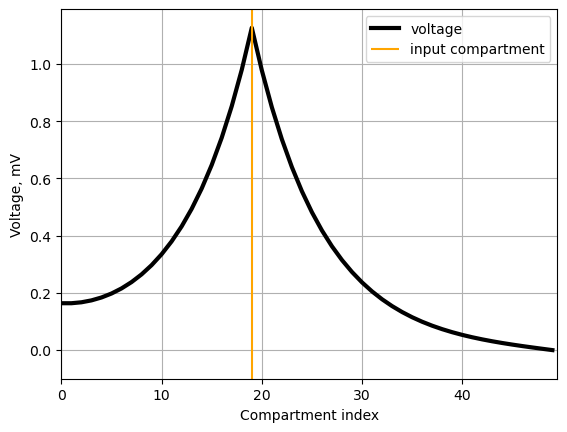

In [112]:
%matplotlib inline
V = V_step[-1] * 1000
plt.plot(V, linewidth=3, color='black', label='voltage')
y_min, y_max = np.min(V) - 0.1, np.max(V) + 0.065
plt.ylim((y_min, y_max))
plt.xlim((0, 49 + 0.5))
plt.grid()
plt.vlines(input_compartment, y_min, y_max, color='orange', label='input compartment')
plt.legend()
plt.xlabel("Compartment index")
plt.ylabel("Voltage, mV")

<b> Your Answer: </b>

The graph shows the quasi-steady state solution for $V(x, t)$, $t \to \infty$. It has several prominent features:
- First, the voltage at input compartment, as it was expected, was the highest.
- The voltage is exponentially decreasing from the both sides of the input compartment
- In the sealed end there indeed is no voltage gradient, as the voltage curve $V(x)$ becomes flat with $x \to 0$.
- In the killer end the spatial derivative of the voltage is non-zero, however voltage itself satisfies boundary condition with $V(49) = 0$

In [110]:
V_peak = V_step[-1, input_compartment]
print(V_peak)
R_parallel = (1/(1/R_a + 1/R_m))
R_consecutive = R_a + R_m
print(I_0 * R_parallel)
print(I_0 * R_consecutive)

0.0011265931774907783
0.0003117647058823529
0.016218


<div class="alert alert-block alert-success">
<b>Task:</b> Plot your entire solution in a 3D plot over space and time.
      
<i>Hint:</i> You may simply adapt the code alreay provided. The np.meshgrid function creates the grid over which to plot the surface.
</div>

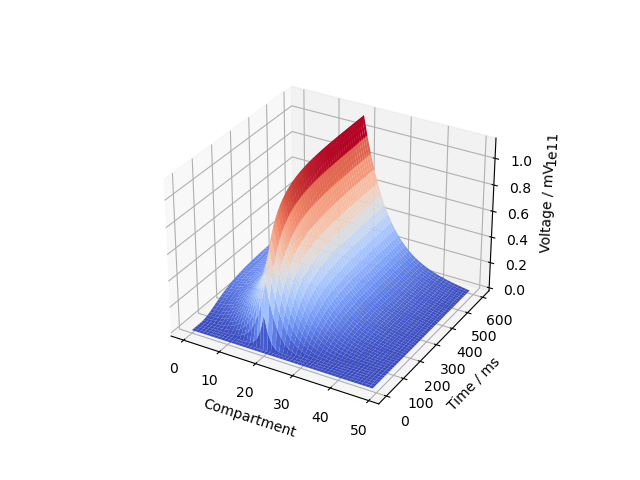

In [39]:
# Make plot interactive
%matplotlib widget

V = V_step

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(time_axis * 1000, range(N))

### YOUR CODE HERE ###

ax.plot_surface(Y, X, V.T * 1000, cmap=cm.coolwarm)
ax.set_xlabel('Compartment')
ax.set_ylabel('Time / ms')
ax.set_zlabel('Voltage / mV')
plt.show()

### YOUR CODE HERE ###

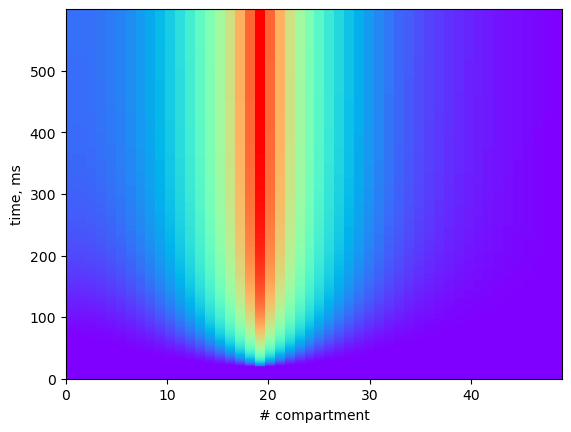

In [81]:
# Make plot interactive
%matplotlib inline

V = V_step

plt.imshow(V, origin='lower', aspect='auto', interpolation='none', extent=[0, 49, 0, np.max(time_axis) * 1000])
plt.xlabel("# compartment")
plt.ylabel("time, ms")
plt.show()

### YOUR CODE HERE ###

Since we have the model implemented, we can without much hassle study the effect of a rectangular input current. We only need to implement the current function and then rerun our previous code. More precisely, consider the current input function
$$
I_e(t) = 
\begin{cases}
0, & (t < t_e) \vee (t_s \leq t) \vee (j\neq j_e) \\
I_1, & (t_e \leq t < t_s) \wedge (j = j_e)
\end{cases}.
$$

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the function rectangle_input() to implement the rectangular input for $t_e = 0.02$ and $t_s = 0.4$.
</div>

In [25]:
def rectangle_input(t, N, input_compartment, I_1):
    '''Implements the rectangle-input function.

    Args:
        t: Time in seconds
        N: Number of compartments in the model
        input_compartment: Compartment in which the current is injected
        I_1: The value of the input current

    Returns:
        The input current at a given time as a np.array of length N
    '''

    ### YOUR CODE HERE
    t_e = 0.02 # sec
    t_s = 0.4 
    
    I = np.zeros(N)
    I[input_compartment] = I_1 * int((t >= t_e) & (t < t_s))
    
    return I
    
    ### YOUR CODE HERE ###

<div class="alert alert-block alert-success">
<b>Task:</b> Run the Euler approximation for the rectangular input with $I_1 = 100pA$. Plot the result in a 3D plot over space and time.
</div>

In [70]:
%%time
### YOUR CODE HERE ###

N_times = len(time_axis)

V = np.zeros((N_times, N_compartments))

for i_time in range(N_times - 1):
    for i_compartment in range(N_compartments-1, -1, -1):
        I_input = rectangle_input(time_axis[i_time], N_compartments, input_compartment, I_0)
        if i_compartment == 0:
            V[i_time + 1, :] = sealed_compartment_step(V[i_time, :], I_input, i_compartment, E_m, C_m, R_m, R_a, delta_t)
        elif i_compartment == 49:
            V[i_time + 1, :] = killed_compartment_step(V[i_time, :], I_input, i_compartment, E_m, C_m, R_m, R_a, delta_t)
        else:
            V[i_time + 1, :] = surrounded_compartment_step(V[i_time, :], I_input, i_compartment, E_m, C_m, R_m, R_a, delta_t)
            
            
V_rec = V.copy()
            
### YOUR CODE HERE ###

CPU times: total: 2.97 s
Wall time: 2.97 s


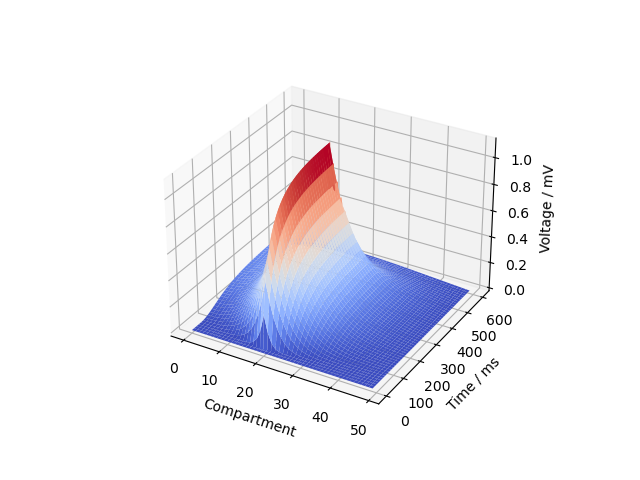

In [111]:
# Make plot interactive
%matplotlib widget

V = V_rec

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(time_axis * 1000, range(N))

### YOUR CODE HERE ###

ax.plot_surface(Y, X, V.T * 1000, cmap = cm.coolwarm)
ax.set_xlabel('Compartment')
ax.set_ylabel('Time / ms')
ax.set_zlabel('Voltage / mV')
plt.show()

### YOUR CODE HERE ###

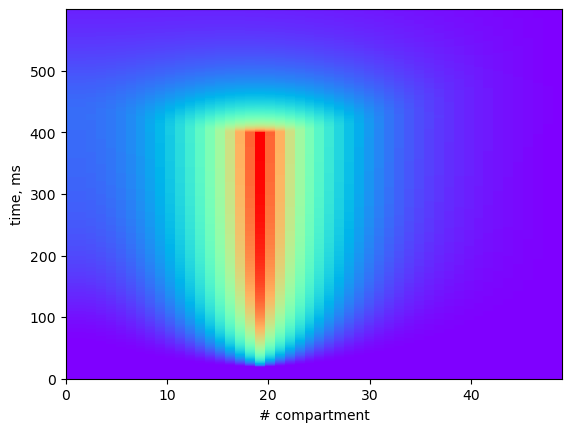

In [82]:
%matplotlib inline

V = V_rec

plt.imshow(V, origin='lower', aspect='auto', interpolation='none', extent=[0, 49, 0, np.max(time_axis) * 1000])
plt.xlabel("# compartment")
plt.ylabel("time, ms")
plt.show()